In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import joblib
import os
import itertools

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')


In [2]:
DATA_DIR = 'data/processed/'
OUTPUT_DIR = 'data/models/arima/'

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}residuals/', exist_ok=True)

print("Loading prepared datasets...")
print("="*80)

# Load ARIMA-ready CORE datasets (gap-filled for compatibility)
p1a_train = pd.read_csv(f'{DATA_DIR}p1a_core_train_arima.csv')
p1a_val = pd.read_csv(f'{DATA_DIR}p1a_core_val_arima.csv')
p1a_test = pd.read_csv(f'{DATA_DIR}p1a_core_test_arima.csv')
print(f"[LOADED] P1A Core (ARIMA-ready): Train={p1a_train.shape}, Val={p1a_val.shape}, Test={p1a_test.shape}")

p3a_train = pd.read_csv(f'{DATA_DIR}p3a_core_train_arima.csv')
p3a_val = pd.read_csv(f'{DATA_DIR}p3a_core_val_arima.csv')
p3a_test = pd.read_csv(f'{DATA_DIR}p3a_core_test_arima.csv')
print(f"[LOADED] P3A Core (ARIMA-ready): Train={p3a_train.shape}, Val={p3a_val.shape}, Test={p3a_test.shape}")

targets_train = pd.read_csv(f'{DATA_DIR}targets_train.csv')
targets_val = pd.read_csv(f'{DATA_DIR}targets_val.csv')
targets_test = pd.read_csv(f'{DATA_DIR}targets_test.csv')
print(f"[LOADED] Targets: Train={targets_train.shape}, Val={targets_val.shape}, Test={targets_test.shape}")

for df in [p1a_train, p1a_val, p1a_test, p3a_train, p3a_val, p3a_test, targets_train, targets_val, targets_test]:
    df['Date'] = pd.to_datetime(df['Date'])

print("\n" + "="*80)
print("All datasets loaded successfully!")
print("="*80)

Loading prepared datasets...
[LOADED] P1A Core (ARIMA-ready): Train=(705, 13), Val=(125, 13), Test=(326, 13)
[LOADED] P3A Core (ARIMA-ready): Train=(705, 13), Val=(125, 13), Test=(326, 13)
[LOADED] Targets: Train=(705, 11), Val=(125, 11), Test=(326, 11)

All datasets loaded successfully!


In [3]:
def test_stationarity(series, name):
    adf_result = adfuller(series.dropna(), autolag='AIC')
    adf_statistic, adf_pvalue = adf_result[0], adf_result[1]
    
    kpss_result = kpss(series.dropna(), regression='ct', nlags='auto')
    kpss_statistic, kpss_pvalue = kpss_result[0], kpss_result[1]
    
    is_stationary = (adf_pvalue < 0.05) and (kpss_pvalue > 0.05)
    
    print(f"\n{name}:")
    print(f"  ADF Statistic: {adf_statistic:.4f}, p-value: {adf_pvalue:.4f} {'(Stationary)' if adf_pvalue < 0.05 else '(Non-stationary)'}")
    print(f"  KPSS Statistic: {kpss_statistic:.4f}, p-value: {kpss_pvalue:.4f} {'(Stationary)' if kpss_pvalue > 0.05 else '(Non-stationary)'}")
    print(f"  DECISION: {'STATIONARY' if is_stationary else 'NON-STATIONARY (needs differencing)'}")
    
    return is_stationary, {
        'adf_stat': adf_statistic,
        'adf_pval': adf_pvalue,
        'kpss_stat': kpss_statistic,
        'kpss_pval': kpss_pvalue,
        'is_stationary': is_stationary
    }

print("Testing stationarity of target series...")
print("="*80)

p1a_stationary, p1a_results = test_stationarity(targets_train['P1A_82'], "P1A_82 (Atlantic)")
p3a_stationary, p3a_results = test_stationarity(targets_train['P3A_82'], "P3A_82 (Pacific)")

print("\n" + "="*80)
print("Stationarity testing complete!")
print("="*80)

Testing stationarity of target series...

P1A_82 (Atlantic):
  ADF Statistic: -1.9395, p-value: 0.3137 (Non-stationary)
  KPSS Statistic: 0.2682, p-value: 0.0100 (Non-stationary)
  DECISION: NON-STATIONARY (needs differencing)

P3A_82 (Pacific):
  ADF Statistic: -1.8842, p-value: 0.3395 (Non-stationary)
  KPSS Statistic: 0.2097, p-value: 0.0124 (Non-stationary)
  DECISION: NON-STATIONARY (needs differencing)

Stationarity testing complete!


Plotting ACF/PACF for target series...


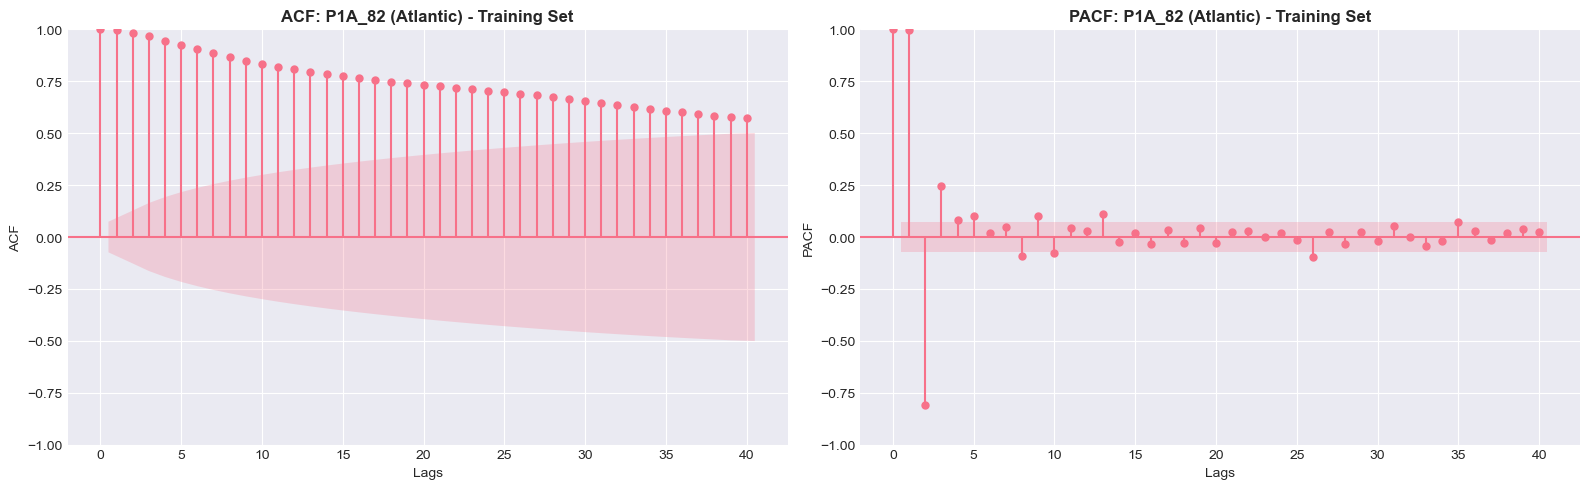

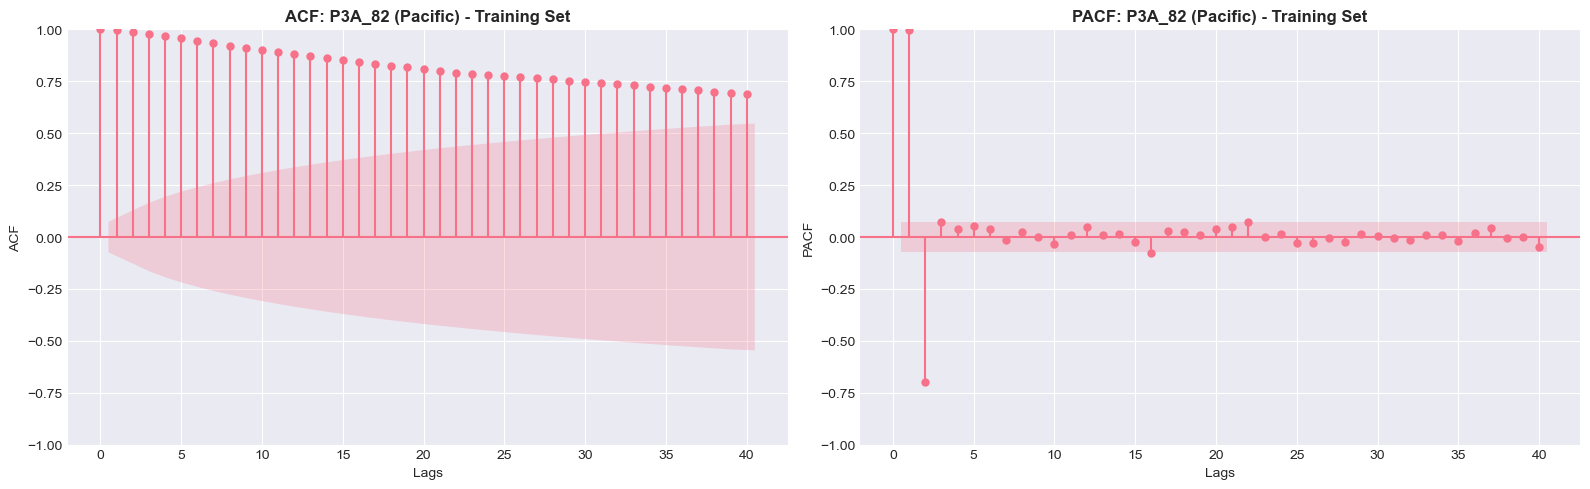


ACF/PACF plots complete.


In [4]:
def plot_acf_pacf(series, title, lags=40):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    plot_acf(series.dropna(), lags=lags, ax=ax1, alpha=0.05)
    ax1.set_title(f'ACF: {title}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Lags')
    ax1.set_ylabel('ACF')
    
    plot_pacf(series.dropna(), lags=lags, ax=ax2, alpha=0.05, method='ywm')
    ax2.set_title(f'PACF: {title}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Lags')
    ax2.set_ylabel('PACF')
    
    plt.tight_layout()
    plt.show()

print("Plotting ACF/PACF for target series...")
print("="*80)

plot_acf_pacf(targets_train['P1A_82'], "P1A_82 (Atlantic) - Training Set", lags=40)
plot_acf_pacf(targets_train['P3A_82'], "P3A_82 (Pacific) - Training Set", lags=40)

print("\nACF/PACF plots complete.")

In [5]:
def grid_search_sarima(series, seasonal_m=5, max_order=2):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    
    p_range = range(0, max_order + 1)
    d_range = range(0, 2)
    q_range = range(0, max_order + 1)
    P_range = range(0, 2)
    D_range = range(0, 2)
    Q_range = range(0, 2)
    
    print(f"Testing {len(p_range) * len(d_range) * len(q_range) * len(P_range) * len(D_range) * len(Q_range)} combinations...")
    
    tested = 0
    for p, d, q, P, D, Q in itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range):
        try:
            model = SARIMAX(
                series,
                order=(p, d, q),
                seasonal_order=(P, D, Q, seasonal_m),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fitted = model.fit(disp=False, maxiter=50)
            
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_order = (p, d, q)
                best_seasonal_order = (P, D, Q, seasonal_m)
                print(f"  New best: SARIMA{best_order}x{best_seasonal_order} - AIC: {best_aic:.2f}")
            
            tested += 1
            if tested % 20 == 0:
                print(f"  Tested {tested} models...")
                
        except:
            continue
    
    print(f"\nBest model found: SARIMA{best_order}x{best_seasonal_order}")
    print(f"Best AIC: {best_aic:.2f}")
    
    return best_order, best_seasonal_order, best_aic

print("Running grid search for optimal order selection...")
print("="*80)

print("\nP1A_82 (Atlantic) - SARIMA Grid Search:")
print("-" * 80)
p1a_order, p1a_seasonal_order, p1a_best_aic = grid_search_sarima(
    targets_train['P1A_82'].dropna(),
    seasonal_m=5,
    max_order=2
)

print("\n" + "="*80)
print("\nP3A_82 (Pacific) - SARIMA Grid Search:")
print("-" * 80)
p3a_order, p3a_seasonal_order, p3a_best_aic = grid_search_sarima(
    targets_train['P3A_82'].dropna(),
    seasonal_m=5,
    max_order=2
)

print("\n" + "="*80)
print("Grid search complete!")
print("="*80)

Running grid search for optimal order selection...

P1A_82 (Atlantic) - SARIMA Grid Search:
--------------------------------------------------------------------------------
Testing 144 combinations...
  New best: SARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC: 16069.39
  New best: SARIMA(0, 0, 0)x(0, 0, 1, 5) - AIC: 15472.78
  New best: SARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC: 13352.36
  New best: SARIMA(0, 0, 0)x(0, 1, 1, 5) - AIC: 13255.83
  New best: SARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC: 12457.40
  New best: SARIMA(0, 0, 2)x(0, 1, 0, 5) - AIC: 11698.84
  New best: SARIMA(0, 0, 2)x(0, 1, 1, 5) - AIC: 11579.11
  Tested 20 models...
  New best: SARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC: 11458.45
  New best: SARIMA(0, 1, 0)x(0, 0, 1, 5) - AIC: 11381.77
  New best: SARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC: 11338.83
  New best: SARIMA(0, 1, 1)x(0, 0, 0, 5) - AIC: 10909.92
  New best: SARIMA(0, 1, 1)x(0, 0, 1, 5) - AIC: 10834.26
  New best: SARIMA(0, 1, 1)x(0, 1, 1, 5) - AIC: 10788.93
  Tested 40 models...
  New best: SA

In [6]:
def train_sarimax(endog_train, exog_train, order, seasonal_order, name):
    print(f"\nTraining {name} SARIMAX{order}x{seasonal_order}...")
    
    exog_cols = [c for c in exog_train.columns if c != 'Date']
    X_train = exog_train[exog_cols].values
    
    model = SARIMAX(
        endog_train,
        exog=X_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    fitted_model = model.fit(disp=False, maxiter=200)
    
    print(f"  AIC: {fitted_model.aic:.2f}")
    print(f"  BIC: {fitted_model.bic:.2f}")
    print(f"  Training complete!")
    
    return fitted_model

print("Training SARIMAX models...")
print("="*80)

p1a_model = train_sarimax(
    targets_train['P1A_82'].dropna(),
    p1a_train,
    p1a_order,
    p1a_seasonal_order,
    "P1A_82 (Atlantic)"
)

p3a_model = train_sarimax(
    targets_train['P3A_82'].dropna(),
    p3a_train,
    p3a_order,
    p3a_seasonal_order,
    "P3A_82 (Pacific)"
)

print("\n" + "="*80)
print("SARIMAX models trained successfully!")
print("="*80)

Training SARIMAX models...

Training P1A_82 (Atlantic) SARIMAX(2, 1, 2)x(1, 1, 1, 5)...
  AIC: 10743.06
  BIC: 10829.28
  Training complete!

Training P3A_82 (Pacific) SARIMAX(1, 1, 2)x(1, 1, 1, 5)...
  AIC: 10335.06
  BIC: 10416.75
  Training complete!

SARIMAX models trained successfully!


In [7]:
def generate_forecasts(model, endog_val, exog_val, name):
    print(f"\nGenerating forecasts for {name}...")
    
    exog_cols = [c for c in exog_val.columns if c != 'Date']
    X_val = exog_val[exog_cols].values
    
    forecast_result = model.get_forecast(steps=len(endog_val), exog=X_val)
    forecast = forecast_result.predicted_mean
    
    print(f"  Forecast shape: {forecast.shape}")
    print(f"  Actuals shape: {endog_val.shape}")
    
    return forecast.values, endog_val.values

print("Generating validation forecasts...")
print("="*80)

p1a_forecast_val, p1a_actual_val = generate_forecasts(
    p1a_model,
    targets_val['P1A_82'].dropna(),
    p1a_val,
    "P1A_82 (Atlantic)"
)

p3a_forecast_val, p3a_actual_val = generate_forecasts(
    p3a_model,
    targets_val['P3A_82'].dropna(),
    p3a_val,
    "P3A_82 (Pacific)"
)

print("\n" + "="*80)
print("Validation forecasts generated!")
print("="*80)

Generating validation forecasts...

Generating forecasts for P1A_82 (Atlantic)...
  Forecast shape: (125,)
  Actuals shape: (125,)

Generating forecasts for P3A_82 (Pacific)...
  Forecast shape: (125,)
  Actuals shape: (125,)

Validation forecasts generated!


In [8]:
def evaluate_forecast(forecast, actual, name):
    min_len = min(len(forecast), len(actual))
    forecast = forecast[:min_len]
    actual = actual[:min_len]
    
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    
    if len(actual) > 1:
        actual_direction = np.diff(actual) > 0
        forecast_direction = np.diff(forecast) > 0
        dir_accuracy = np.mean(actual_direction == forecast_direction) * 100
    else:
        dir_accuracy = np.nan
    
    print(f"\n{name} - Validation Performance:")
    print("="*80)
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Directional Accuracy: {dir_accuracy:.2f}%")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'dir_accuracy': dir_accuracy
    }

print("Evaluating validation performance...")
print("="*80)

p1a_metrics = evaluate_forecast(
    p1a_forecast_val,
    p1a_actual_val,
    "P1A_82 (Atlantic)"
)

p3a_metrics = evaluate_forecast(
    p3a_forecast_val,
    p3a_actual_val,
    "P3A_82 (Pacific)"
)

print("\n" + "="*80)
print("Performance evaluation complete!")
print("="*80)

Evaluating validation performance...

P1A_82 (Atlantic) - Validation Performance:
  RMSE: $7,573.66
  MAE:  $7,113.69
  MAPE: 52.61%
  Directional Accuracy: 46.77%

P3A_82 (Pacific) - Validation Performance:
  RMSE: $2,477.18
  MAE:  $2,082.62
  MAPE: 13.25%
  Directional Accuracy: 60.48%

Performance evaluation complete!


Plotting forecasts vs actuals...


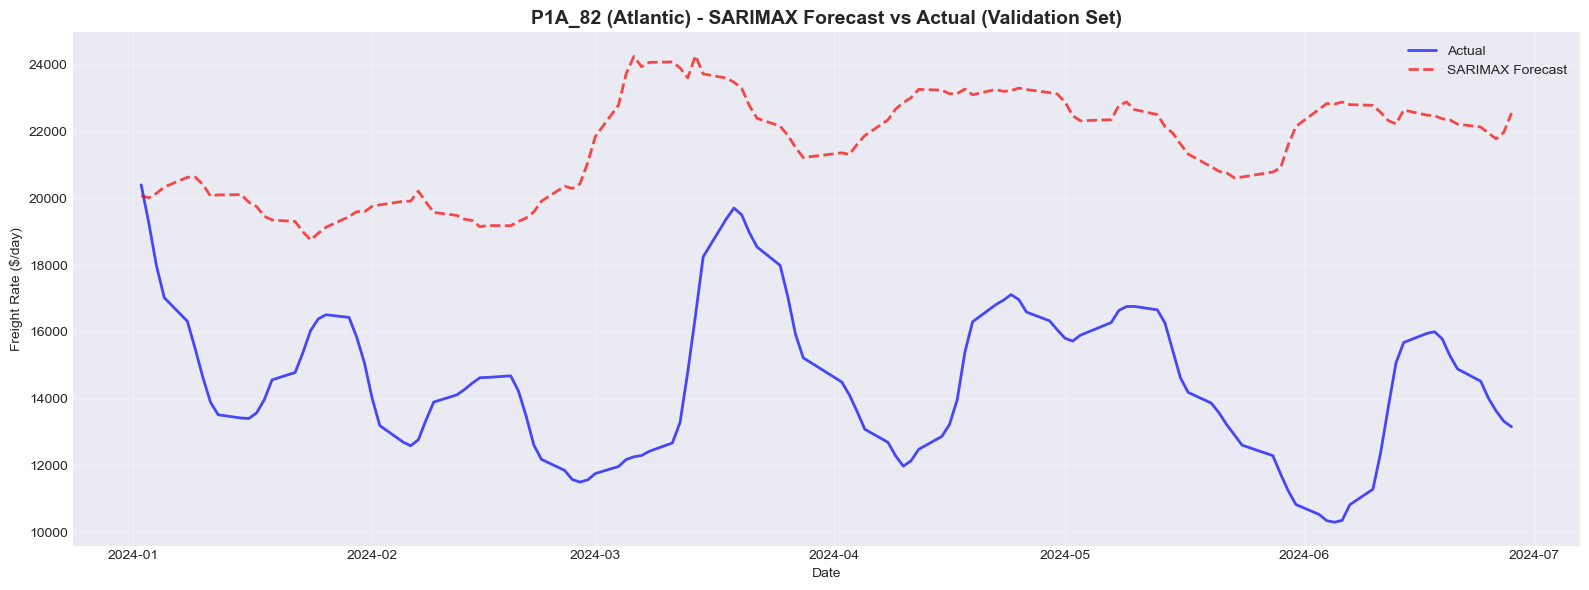

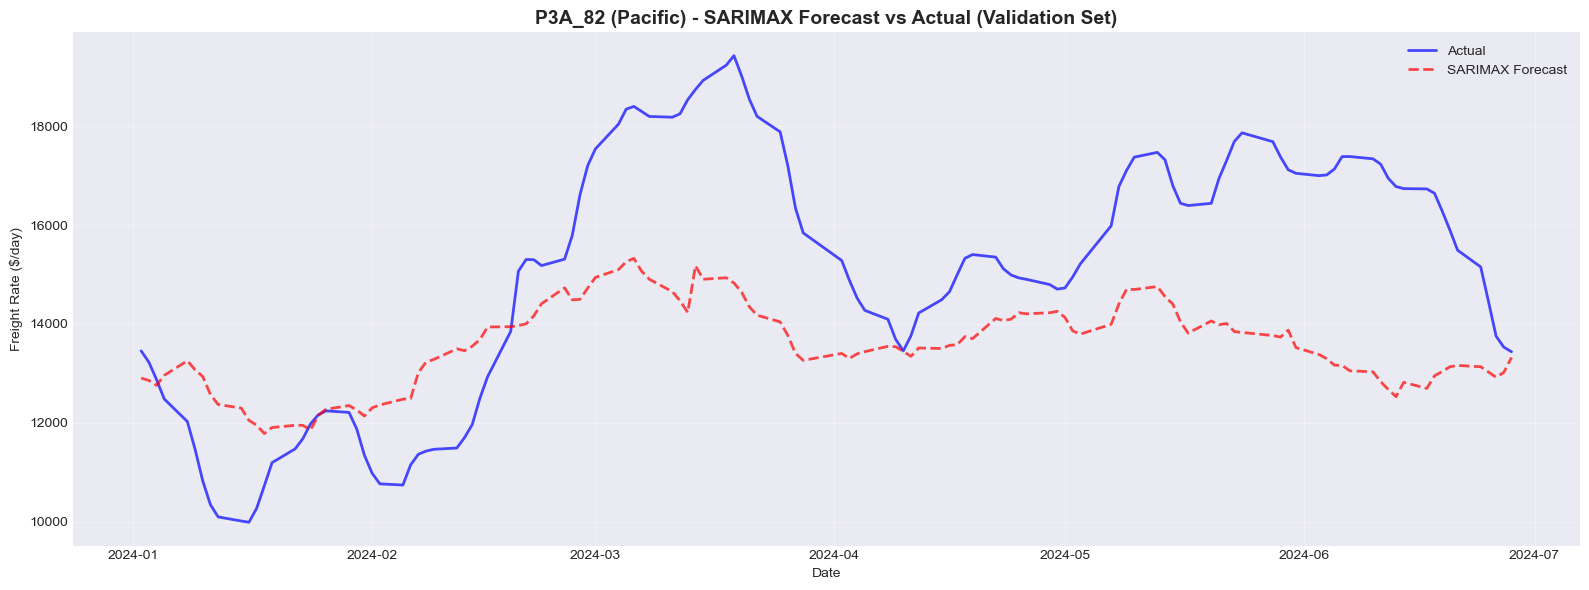

In [9]:
def plot_forecast_vs_actual(dates, forecast, actual, title):
    fig, ax = plt.subplots(figsize=(16, 6))
    
    min_len = min(len(forecast), len(actual), len(dates))
    
    ax.plot(dates[:min_len], actual[:min_len], label='Actual', linewidth=2, color='blue', alpha=0.7)
    ax.plot(dates[:min_len], forecast[:min_len], label='SARIMAX Forecast', linewidth=2, color='red', linestyle='--', alpha=0.7)
    
    ax.set_title(f'{title} - SARIMAX Forecast vs Actual (Validation Set)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Freight Rate ($/day)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Plotting forecasts vs actuals...")
print("="*80)

plot_forecast_vs_actual(
    targets_val['Date'].values,
    p1a_forecast_val,
    p1a_actual_val,
    "P1A_82 (Atlantic)"
)

plot_forecast_vs_actual(
    targets_val['Date'].values,
    p3a_forecast_val,
    p3a_actual_val,
    "P3A_82 (Pacific)"
)

In [10]:
print("Extracting residuals...")
print("="*80)

p1a_residuals = p1a_model.resid
p3a_residuals = p3a_model.resid

print(f"\nP1A_82 residuals: {len(p1a_residuals)} observations")
print(f"  Mean: {p1a_residuals.mean():.2f}")
print(f"  Std:  {p1a_residuals.std():.2f}")

print(f"\nP3A_82 residuals: {len(p3a_residuals)} observations")
print(f"  Mean: {p3a_residuals.mean():.2f}")
print(f"  Std:  {p3a_residuals.std():.2f}")

pd.DataFrame({
    'Date': targets_train['Date'].iloc[:len(p1a_residuals)],
    'P1A_82_residuals': p1a_residuals.values
}).to_csv(f'{OUTPUT_DIR}residuals/p1a_residuals.csv', index=False)

pd.DataFrame({
    'Date': targets_train['Date'].iloc[:len(p3a_residuals)],
    'P3A_82_residuals': p3a_residuals.values
}).to_csv(f'{OUTPUT_DIR}residuals/p3a_residuals.csv', index=False)

print("\n[SAVED] Residuals saved to data/models/arima/residuals/")
print("="*80)

Extracting residuals...

P1A_82 residuals: 705 observations
  Mean: -27.81
  Std:  1206.91

P3A_82 residuals: 705 observations
  Mean: -2.14
  Std:  1169.68

[SAVED] Residuals saved to data/models/arima/residuals/


In [11]:
print("Saving trained models...")
print("="*80)

joblib.dump(p1a_model, f'{OUTPUT_DIR}p1a_sarimax_model.pkl')
print(f"[SAVED] P1A_82 SARIMAX model: {OUTPUT_DIR}p1a_sarimax_model.pkl")

joblib.dump(p3a_model, f'{OUTPUT_DIR}p3a_sarimax_model.pkl')
print(f"[SAVED] P3A_82 SARIMAX model: {OUTPUT_DIR}p3a_sarimax_model.pkl")

model_info = {
    'p1a': {
        'order': p1a_order,
        'seasonal_order': p1a_seasonal_order,
        'aic': p1a_model.aic,
        'bic': p1a_model.bic,
        'metrics': p1a_metrics
    },
    'p3a': {
        'order': p3a_order,
        'seasonal_order': p3a_seasonal_order,
        'aic': p3a_model.aic,
        'bic': p3a_model.bic,
        'metrics': p3a_metrics
    }
}

joblib.dump(model_info, f'{OUTPUT_DIR}model_info.pkl')
print(f"[SAVED] Model info: {OUTPUT_DIR}model_info.pkl")

print("\n" + "="*80)
print("All models and artifacts saved successfully!")
print("="*80)

Saving trained models...
[SAVED] P1A_82 SARIMAX model: data/models/arima/p1a_sarimax_model.pkl
[SAVED] P3A_82 SARIMAX model: data/models/arima/p3a_sarimax_model.pkl
[SAVED] Model info: data/models/arima/model_info.pkl

All models and artifacts saved successfully!


In [12]:
print("\n" + "="*80)
print("SPRINT 3 PHASE 2 COMPLETE: ARIMA/SARIMA MODELS (RETRAINED WITH LEAK-FREE DATA)")
print("="*80)

print("\nMODELS TRAINED:")
print(f"  P1A_82 (Atlantic): SARIMAX{p1a_order}x{p1a_seasonal_order}")
print(f"  P3A_82 (Pacific):  SARIMAX{p3a_order}x{p3a_seasonal_order}")

print("\nVALIDATION PERFORMANCE:")
print("  P1A_82 (Atlantic):")
print(f"    RMSE: ${p1a_metrics['rmse']:,.2f}")
print(f"    MAE:  ${p1a_metrics['mae']:,.2f}")
print(f"    MAPE: {p1a_metrics['mape']:.2f}%")
print(f"    Dir:  {p1a_metrics['dir_accuracy']:.2f}%")

print("\n  P3A_82 (Pacific):")
print(f"    RMSE: ${p3a_metrics['rmse']:,.2f}")
print(f"    MAE:  ${p3a_metrics['mae']:,.2f}")
print(f"    MAPE: {p3a_metrics['mape']:.2f}%")
print(f"    Dir:  {p3a_metrics['dir_accuracy']:.2f}%")

print("\nOUTPUTS SAVED:")
print(f"  - 2 trained SARIMAX models (P1A, P3A)")
print(f"  - 2 residual files for GARCH modeling")
print(f"  - Model info (orders, AIC, BIC, metrics)")

print("\nNEXT PHASE:")
print("  Phase 3: GARCH Volatility Models (Notebook 05)")

print("\n" + "="*80)
print("Phase 2 Complete!")
print("="*80)


SPRINT 3 PHASE 2 COMPLETE: ARIMA/SARIMA MODELS (RETRAINED WITH LEAK-FREE DATA)

MODELS TRAINED:
  P1A_82 (Atlantic): SARIMAX(2, 1, 2)x(1, 1, 1, 5)
  P3A_82 (Pacific):  SARIMAX(1, 1, 2)x(1, 1, 1, 5)

VALIDATION PERFORMANCE:
  P1A_82 (Atlantic):
    RMSE: $7,573.66
    MAE:  $7,113.69
    MAPE: 52.61%
    Dir:  46.77%

  P3A_82 (Pacific):
    RMSE: $2,477.18
    MAE:  $2,082.62
    MAPE: 13.25%
    Dir:  60.48%

OUTPUTS SAVED:
  - 2 trained SARIMAX models (P1A, P3A)
  - 2 residual files for GARCH modeling
  - Model info (orders, AIC, BIC, metrics)

NEXT PHASE:
  Phase 3: GARCH Volatility Models (Notebook 05)

Phase 2 Complete!
